# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [12]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

#learning_rates = [1e-9, 1e-8, 1e-7]
#regularization_strengths = [5e4, 5e5, 5e6]

learning_rates = [1e-9, 5e-9,1e-8,5e-8, 1e-7]
regularization_strengths = [5e4,1e5, 5e5, 1e6,5e6]

results = {}
best_val = -1
best_svm = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    print('#'*50)
    svm.train(X_train_feats, y_train, learning_rate = lr, reg=reg,num_iters=1500, verbose=False)
    # num_iters = 1500
    y_train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % (train_acc, ))
    y_val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % (val_acc, ))
    results[(lr,reg)] = (train_acc,val_acc)
    if best_val<0:
      best_val = val_acc
      best_svm = svm
    elif best_val < val_acc:
      best_val = val_acc
      best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

##################################################
training accuracy: 0.120020
validation accuracy: 0.109000
##################################################
training accuracy: 0.070673
validation accuracy: 0.062000
##################################################
training accuracy: 0.088020
validation accuracy: 0.070000
##################################################
training accuracy: 0.108571
validation accuracy: 0.109000
##################################################
training accuracy: 0.413918
validation accuracy: 0.410000
##################################################
training accuracy: 0.097551
validation accuracy: 0.090000
##################################################
training accuracy: 0.103796
validation accuracy: 0.104000
##################################################
training accuracy: 0.274041
validation accuracy: 0.271000
##################################################
training accuracy: 0.411449
validation accuracy: 0.412000
###################

In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.417


y_test.shape: (1000,)


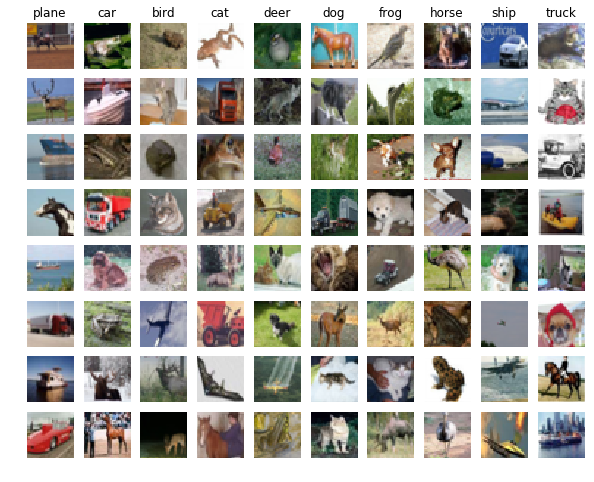

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
print ('y_test.shape:',y_test.shape)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [20]:
print(X_train_feats.shape)
print(X_val_feats.shape)

(49000, 155)
(1000, 155)


In [33]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
#hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
'''
learning_rates = [5e-4, 1e-3]
regularization_strengths = [0.025,0.25]
hidden_sizes = [500,1000]
batch_sizes = [128,256]
'''
learning_rates = np.logspace(-10, 0, 5) # np.logspace(-10, 10, 8) #-10, -9, -8, -7, -6, -5, -4
regularization_strengths = np.logspace(-3, 5, 5)

hidden_sizes = [500]
batch_sizes = [128]

for lr in learning_rates:
  for reg in regularization_strengths:
    for hidden_size in hidden_sizes:
      for batch_size in batch_sizes:
        net = TwoLayerNet(input_dim, hidden_size, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=batch_size,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
        '''
        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print('Validation accuracy: ', val_acc)
         
        # Plot the loss function and train / validation accuracies
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.show()

        '''
        y_train_pred = net.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        print('Parameters: learning rate %f,regulation %f' %(lr,reg,))
        print('training accuracy: %f' % (train_acc, ))
        y_val_pred = net.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (val_acc, ))
       
        results[(lr,reg,hidden_size,batch_size)] = (train_acc,val_acc)
        if best_val<0:
          best_val = val_acc
          best_net = net
        elif best_val < val_acc:
          best_val = val_acc
          best_net = net
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Parameters: learning rate 0.000000,regulation 0.001000
training accuracy: 0.090224
validation accuracy: 0.094000
Parameters: learning rate 0.000000,regulation 0.100000
training accuracy: 0.106061
validation accuracy: 0.110000
Parameters: learning rate 0.000000,regulation 10.000000
training accuracy: 0.092347
validation accuracy: 0.093000
Parameters: learning rate 0.000000,regulation 1000.000000
training accuracy: 0.111776
validation accuracy: 0.129000
Parameters: learning rate 0.000000,regulation 100000.000000
training accuracy: 0.083510
validation accuracy: 0.085000
Parameters: learning rate 0.000000,regulation 0.001000
training accuracy: 0.093184
validation accuracy: 0.080000
Parameters: learning rate 0.000000,regulation 0.100000
training accuracy: 0.073408
validation accuracy: 0.071000
Parameters: learning rate 0.000000,regulation 10.000000
training accuracy: 0.089265
validation accuracy: 0.084000
Parameters: learning rate 0.000000,regulation 1000.000000
training accuracy: 0.101204


cs231n/classifiers/neural_net.py:119: RuntimeWarning: divide by zero encountered in log
  loss = np.sum( -np.log( np.choose(y,scores.T).reshape((N,1))/ss ) )
cs231n/classifiers/neural_net.py:122: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1*W1) + np.sum(b1*b1) + np.sum(W2*W2) + np.sum(b2*b2))
cs231n/classifiers/neural_net.py:116: RuntimeWarning: overflow encountered in subtract
  scores -= M
cs231n/classifiers/neural_net.py:116: RuntimeWarning: invalid value encountered in subtract
  scores -= M
cs231n/classifiers/neural_net.py:85: RuntimeWarning: invalid value encountered in greater
  bool_idx1 = (layer1>0)
cs231n/classifiers/neural_net.py:165: RuntimeWarning: invalid value encountered in greater
  bool_idx1 = (layer1>0)


Parameters: learning rate 0.003162,regulation 1000.000000
training accuracy: 0.100265
validation accuracy: 0.087000


cs231n/classifiers/neural_net.py:122: RuntimeWarning: overflow encountered in multiply
  loss += reg * (np.sum(W1*W1) + np.sum(b1*b1) + np.sum(W2*W2) + np.sum(b2*b2))


Parameters: learning rate 0.003162,regulation 100000.000000
training accuracy: 0.100265
validation accuracy: 0.087000
Parameters: learning rate 1.000000,regulation 0.001000
training accuracy: 0.596041
validation accuracy: 0.575000
Parameters: learning rate 1.000000,regulation 0.100000
training accuracy: 0.239245
validation accuracy: 0.249000
Parameters: learning rate 1.000000,regulation 10.000000
training accuracy: 0.100265
validation accuracy: 0.087000
Parameters: learning rate 1.000000,regulation 1000.000000
training accuracy: 0.100265
validation accuracy: 0.087000
Parameters: learning rate 1.000000,regulation 100000.000000
training accuracy: 0.100265
validation accuracy: 0.087000


In [45]:
net = TwoLayerNet(input_dim, hidden_size, num_classes)

best_net = net
# Train the network

stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=1.0, learning_rate_decay=0.95,
            reg=0.001, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.460024
iteration 200 / 2000: loss 1.443861
iteration 300 / 2000: loss 1.425600
iteration 400 / 2000: loss 1.286527
iteration 500 / 2000: loss 1.389185
iteration 600 / 2000: loss 1.388413
iteration 700 / 2000: loss 1.297148
iteration 800 / 2000: loss 1.341767
iteration 900 / 2000: loss 1.288157
iteration 1000 / 2000: loss 1.254766
iteration 1100 / 2000: loss 1.318018
iteration 1200 / 2000: loss 1.196916
iteration 1300 / 2000: loss 1.329154
iteration 1400 / 2000: loss 1.287558
iteration 1500 / 2000: loss 1.234835
iteration 1600 / 2000: loss 1.327357
iteration 1700 / 2000: loss 1.174153
iteration 1800 / 2000: loss 1.068980
iteration 1900 / 2000: loss 1.263137
Validation accuracy:  0.594


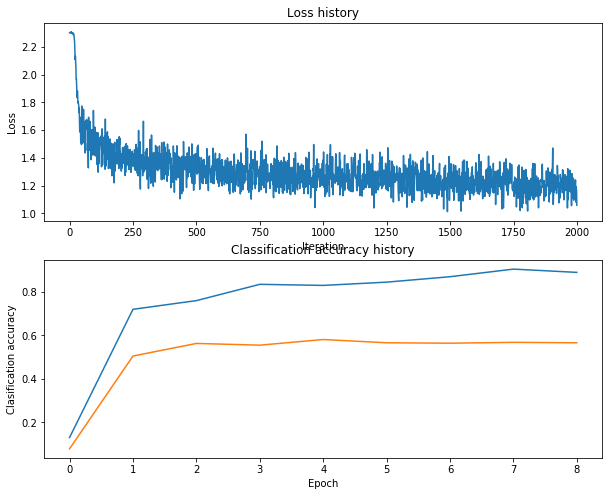

In [46]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [47]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.593


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!